In [0]:
# подключение гугл диска, с нужными файлами
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# нужные библиотеки
import numpy as np
import pandas as pd
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import t, norm, gamma
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 5 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [0]:
data1 = pd.read_csv('/content/drive/My Drive/test_1_1.csv', sep=';')

Fitted gamma distribution with error=0.006212492106400751)
Fitted rayleigh distribution with error=0.003624237542648453)
Fitted uniform distribution with error=0.006428252153899087)
Fitted expon distribution with error=0.0005119513270550745)
Fitted powerlaw distribution with error=0.004562170581207799)
Fitted lognorm distribution with error=0.005118789919616755)


,sumsquare_error,aic,bic,kl_div
expon,0.000512,11347.281405,-6.201608e+06,inf
rayleigh,0.003624,53036.839943,-5.601072e+06,inf
powerlaw,0.004562,1584.813202,-5.530439e+06,inf
lognorm,0.005119,1942.156671,-5.495116e+06,inf
gamma,0.006212,65912.578359,-5.435698e+06,inf


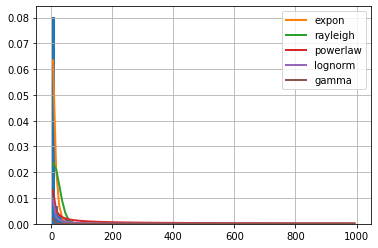

In [0]:
# just to keep in mind
# ! pip install fitter
# from fitter import Fitter
# f = Fitter(X, distributions=['gamma', 'rayleigh', 'uniform', 'expon', 'powerlaw', 'lognorm'])
# f.fit()
# f.summary()

# Part 1
## находим наблюдения за 5 и 95 перцентиль

Для этого применяем стандартную функцию из numpy и подсчитываем процент данных, которые меньше 5 и больше 95 *перцентиля*

In [0]:
perc5, perc95= np.percentile(data1.metrics.values,[5,95])
perc5, perc95

(1.0, 52.0)

In [0]:
print('Процент наблюдений, выходящих за 5 и 95 перцентиль: {}'.format((sum(data1.metrics.values < perc5) + sum(data1.metrics.values > perc95))/len(data1)* 100))

Процент наблюдений, выходящих за 5 и 95 перцентиль: 4.987306046493438


# Part 2 
## смотрим на распределение


С данным заданием несколько сложнее. Если для искусственно сгенерированных данных можно задать распределение и ои будут ему идеально соответствовать, то с реальные данные, строго говоря, вряд ли 100 процентов соответствуют какому-то определенному распределению, но нужно найти на какое распределение больше похоже то, с которым мы работаем. Для этого построим график распределения, проверим (чисто на всякий) на разные тесты на нормальность, построим куку-плот и постараемся найти какой-нибудь gof  тест, релевантный для данной ситуации.

In [0]:
data1.metrics.value_counts()

1      132041
2       38880
3       21902
4       14785
5       10608
        ...  
357         1
285         1
355         1
354         1
367         1
Name: metrics, Length: 338, dtype: int64

Почти 50 (!) процентов данных - единицы. Видим, что просто ОГРОМНОЕ количество единичек

In [0]:
data1.metrics.describe()

count    306839.000000
mean         10.146275
std          22.627378
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max         998.000000
Name: metrics, dtype: float64

In [0]:
data1.metrics.median()

2.0

In [0]:
X = data1['metrics'].values 

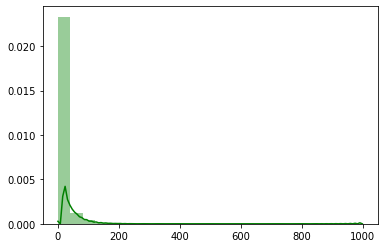

In [0]:
fig, ax = plt.subplots()
sns.distplot(X, bins=25, color="g", ax=ax)
plt.show()

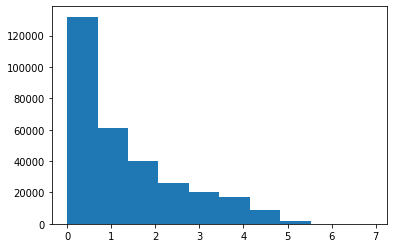

In [0]:
# можно еще вот так посмотреть
X_tr = np.log(X)
plt.hist(np.log(X))
plt.show()

Распределение явно нельзя назвать нормальным... На первый взгляд оно очень сильно скошено вправо. 


Куку плот джаст фор санити чек. Распределение явно не относится к нормальному

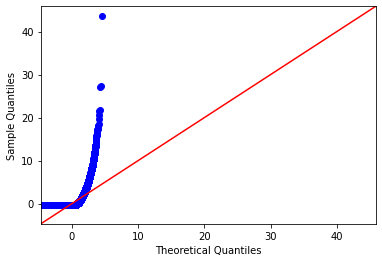

In [0]:
from statsmodels.api import qqplot
fig = qqplot(X, norm, line='45', fit=True)

Симметрия распределения. Получено положительное число - что соответствует графику. Распределение скошено вправо - большая часть находится слева. Тест на длину хвостика распределения - он и правда длинный. Ну и на последок данный тест на нормальность выдает очень большое значение, что говорит о том, что распределение далеко от нормального

In [0]:
stats.skew(X) 

5.2318043311582585

In [0]:
stats.kurtosis(X)

51.91235341063037

In [0]:
stats.jarque_bera(X)

(35853875.606423475, 0.0)

Тут кси тест - ничего хорошего не вышло...

In [0]:
size = len(X)

In [0]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import scipy
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(X, percentile_bins)
observed_frequency, bins = (np.histogram(X, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(X)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(X, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)

# забыла ссылку на код, где-то на просторах стаковэрфлоу


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  chi_square  p_value
0         beta         NaN      0.0
1        expon         NaN      0.0
2        gamma         NaN      0.0
3      lognorm         NaN      0.0
4         norm         NaN      0.0
5     pearson3         NaN      0.0
6       triang         NaN      0.0
7      uniform         NaN      0.0
8  weibull_min         NaN      0.0
9  weibull_max         NaN      0.0


Тут Колмогоров-Смирнов - тоже ерунда какая-то

In [0]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "expon", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "gamma", "lognorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]


# забыла ссылку на код, где-то на просторах стаковэрфлоу

In [0]:
get_best_distribution(X)

p value for norm = 0.0
p value for expon = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 0.0
p value for genextreme = 0.0
p value for gamma = 0.0
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (10.146275408276, 22.627341073666926)


('norm', 0.0, (10.146275408276, 22.627341073666926))

На данном этапе однозначно, что распределение НЕ относится к нормальному. Далее пробувем тесты для сравнения выборки с другими распределениями. В голову пришел gof тест Колмогорова-Смирнова, однако он предназначен для непрерывных распределений и его результаты оказались невалидны, кси, однако тоже результатов не принес.  Единственное, удалось выделить следующие особенности данных.
## Особенности данных по моим наблюдениям:
* Прежде всего данные представляют собой какую-то метрику, при этом принимают только положительные значения и, кажется, имеют дискретное распределение
* В данных наблюдается большой размах и дисперсия
* Почти 50 процентов - это единицы (1 соответственно являются модой распределения)
* Очень длинный 
хвост - распределение сильно скошено вправо, среднее 10, медиана 2, максимум 998...)

О чем же все это говорит? Распределение дискретное, скошенное вправо, скорее всего подчиняется закону Бенфорда: https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%91%D0%B5%D0%BD%D1%84%D0%BE%D1%80%D0%B4%D0%B0
 
Если смотреть на самые частые распределения, похоже вроде на распределение Больцмана, геометрическое(дискретное, скошено, последовательность мода-медиана-среднее). Похоже и на экспоненциальное и гамма, логнормал, если считать, что распределение все-таки непрерывно. Однако, ни один тест тесты это не подтверждает...

In [0]:
from scipy import stats
from statsmodels.stats import gof

poissrvs =  X
# stats.poisson.rvs(0.6, size = 200)

freq, expfreq, histsupp = gof.gof_binning_discrete(poissrvs, stats.poisson, (0.6,), nsupp=20)
(chi2val, pval) = stats.chisquare(freq, expfreq)
print(chi2val, pval)

print(gof.gof_chisquare_discrete(stats.poisson, (0.6,), poissrvs, 0.05,
                                     'Poisson'))

2520207.042623411 0.0
(2520207.042623411, 0.0, False, 'chisquare - test for Poissonat arg = (0.6,) with pval = 0.0')


In [0]:
from scipy import stats
from statsmodels.stats import gof

poissrvs =  X
# stats.poisson.rvs(0.6, size = 200)

freq, expfreq, histsupp = gof.gof_binning_discrete(poissrvs, stats.logser, (0.1,), nsupp=20)
(chi2val, pval) = stats.chisquare(freq, expfreq)
print(chi2val, pval)

print(gof.gof_chisquare_discrete(stats.logser, (0.1,), poissrvs, 0.05,
                                     'Logser'))

164205701.9000185 0.0
(164205701.9000185, 0.0, False, 'chisquare - test for Logserat arg = (0.1,) with pval = 0.0')


In [0]:
from scipy import stats
from statsmodels.stats import gof

poissrvs =  X
# stats.poisson.rvs(0.6, size = 200)

freq, expfreq, histsupp = gof.gof_binning_discrete(poissrvs, stats.boltzmann, (1,1000), nsupp=20)
(chi2val, pval) = stats.chisquare(freq, expfreq)
print(chi2val, pval)

print(gof.gof_chisquare_discrete(stats.boltzmann, (1,100), poissrvs, 0.05,
                                     'Boltzmann'))

1204372.7430230158 0.0
(1204372.7430230158, 0.0, False, 'chisquare - test for Boltzmannat arg = (1, 100) with pval = 0.0')


In [0]:
from scipy import stats
from statsmodels.stats import gof

poissrvs =  X
# stats.poisson.rvs(0.6, size = 200)

freq, expfreq, histsupp = gof.gof_binning_discrete(poissrvs, stats.planck, (10,), nsupp=20)
(chi2val, pval) = stats.chisquare(freq, expfreq)
print(chi2val, pval)

print(gof.gof_chisquare_discrete(stats.planck, (10,), poissrvs, 0.05,
                                     'Planck'))

6758271899.011821 0.0
(6758271899.011821, 0.0, False, 'chisquare - test for Planckat arg = (10,) with pval = 0.0')


In [0]:
from scipy import stats
from statsmodels.stats import gof

poissrvs =  X
# stats.poisson.rvs(0.6, size = 200)

freq, expfreq, histsupp = gof.gof_binning_discrete(poissrvs, stats.geom, (0.6,), nsupp=20)
(chi2val, pval) = stats.chisquare(freq, expfreq)
print(chi2val, pval)

print(gof.gof_chisquare_discrete(stats.geom, (0.6,), poissrvs, 0.05,
                                     'Geom'))

2363432.050752126 0.0
(2363432.050752126, 0.0, False, 'chisquare - test for Geomat arg = (0.6,) with pval = 0.0')


 ## Вывод:
Однозначное заключение о принадлежности к какому-либо рапределения или хотя бы определенной схожестью сделать не удалось. Визуально напоминает гамма или экспоненциальное


**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [0]:
data2 = pd.read_csv('/content/drive/My Drive/test_1_2.csv', sep=';')

In [0]:
data2.head(10)

,Unnamed: 0,variant,metrics
0,1,A,1
1,2,B,1
2,3,A,4
3,4,B,37
4,5,B,4
5,6,B,1
6,7,B,3
7,8,A,15
8,9,B,2
9,10,A,1


In [0]:
data2[data2.variant=='A']['metrics'].describe()

count    92686.000000
mean        10.099562
std         23.130148
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        998.000000
Name: metrics, dtype: float64

In [0]:
data2[data2.variant=='B']['metrics'].describe()

count    91518.000000
mean        10.333137
std         22.860695
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        626.000000
Name: metrics, dtype: float64

In [0]:
A = data2[data2.variant=='A']['metrics'].values
B = data2[data2.variant=='B']['metrics'].values

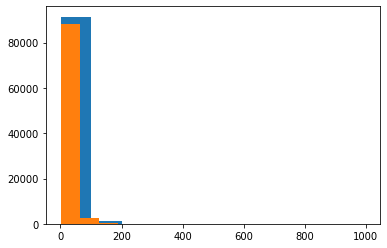

In [0]:
plt.hist(A)
plt.hist(B)
plt.show()

Для каждоого конкретного статистического теста существуют определенные предпосылки и требования к данным,особенно если речь идет о параметрических тестах, к которым принадлежит  T-test
## Требования к данным
Для применения t-критерия Стьюдента данные должны удовлетворять следующим условиям:

##  Несвязные выборки:
* Гомогенность дисперсий - дисперсии внутри наших групп должны быть приблизительно одинаковыми
* Нормальность распределения (особенно важно для выборок с количеством наблюдений меньше 30)

Так что исследуем эти 2 пункта



* Гомогенность дисперсии

р-валью меньше 0.05 - отвергаем гипотезу о гомогенности дисперсий выборок

In [0]:
from scipy.stats import levene, bartlett
levene(A, B, center='median')

LeveneResult(statistic=4.313416821004634, pvalue=0.03781432358426188)

In [0]:
bartlett(A, B)

BartlettResult(statistic=12.644656178448722, pvalue=0.0003766407316960927)

* Нормальность распределения

p-валью 0 - уверенно отвергаем гипотезу о нормальности выборок. Действительно, уже по графику видно, что распределения далеки от нормального

In [0]:
from scipy.stats import shapiro
shapiro(A)

(0.4299488663673401, 0.0)

In [0]:
shapiro(B)

(0.45065927505493164, 0.0)

In [0]:
stats.normaltest(A)

NormaltestResult(statistic=109098.627332008, pvalue=0.0)

In [0]:
stats.normaltest(B)

NormaltestResult(statistic=92329.93783182735, pvalue=0.0)

Ну и смотрим на куку плот, не зря же его проходили, чтобы уже окончательно определиться

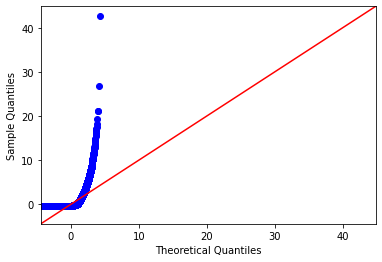

In [0]:
from statsmodels.api import qqplot
fig = qqplot(A, norm, line='45', fit=True)

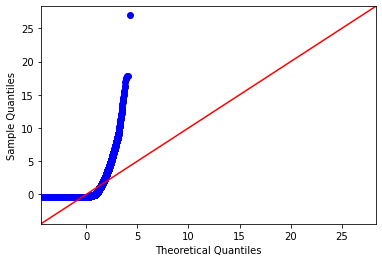

In [0]:
fig = qqplot(B, norm, line='45', fit=True)

Что же, мы видим, что данные не имеют нормальное распределение, а значит, Т-тест в данном случае применять некорректно. В таком случае существует 2 варианта:
* нормализация данных (например, трансформация Бокса-Кокса) и затем применение теста
* применение непараметрических тестов, которые ничего не предполагают о распределении данных


Непараметрическими альтернативами параметрического критерия для двух независимых групп являются: U критерий Манна-Уитни Критерий серий Вальда-Вольфовица, Двухвыборочный критерий Колмогорова-Смирнова (не годится, так как только для непрерывных распределений)

Проверяет, равны ли распределения двух независимых выборок или нет.

Предположения

Наблюдения в каждой выборке независимы и одинаково распределены (iid).
Наблюдения в каждом образце могут быть ранжированы.
интерпретация

H0: распределения обоих образцов равны.
H1: распределения обоих образцов не равны.

Применяем Манна-Уитни:

Полученное значение p-валью маленькое - А и В отличаются?

In [0]:
stats.mannwhitneyu(A, B)

MannwhitneyuResult(statistic=4195358346.0, pvalue=1.365559131227319e-05)

Применяем Крускаль
Тут p-вальюмаленький -  есть различия?

In [0]:
stats.kruskal(A, B)

KruskalResult(statistic=17.596351848720612, pvalue=2.7311177113963818e-05)

Ну и результаты Андерсона тоже позволяет отвергнуть гипотезу, так как  полученная статистика привышает критические знначения (однако, тут не до конца уверена, так как п-валью оч маленькая). Осмелюсь предположить, что п-валью настолько маленькая из-за внушительного размера выборок.

In [0]:
stats.anBderson_ksamp([A, B])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=13.924057721993876, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

И еще welch's test - тоже отвергаем нулевую гипотезу о равном матожидании

In [0]:
stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=-2.1797359369290046, pvalue=0.0292783030047425)

Бокс кокс для приведения. к норм дистрибьшн

In [0]:
A_transformed = stats.boxcox(A)[0]
B_transformed = stats.boxcox(B)[0]

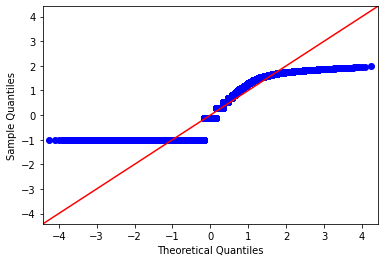

In [0]:
#  ну вышло не очень
fig = qqplot(A_transformed, norm, line='45', fit=True)

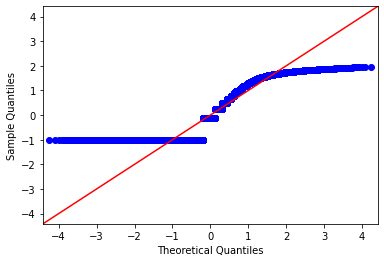

In [0]:
fig = qqplot(B_transformed, norm, line='45', fit=True)

Получилось не очень, но тем не менее пробуем еще и обычный Т-тест на трансформированной выборке.
Согласно тесту, также отвергаем гипотезу о равенстве средних распределений 2 выборок: п-валью маленькая - отвергаем гипотезу

In [0]:
stats.ttest_ind(A_transformed, B_transformed)

Ttest_indResult(statistic=-8.28018100559844, pvalue=1.2379802718156532e-16)

## Вывод

Распределение данных не является нормальным, а их дисперсии не гомогенны, значит предпосылки для т-теста отсутствуют - используем непараметрические критерии, также можно пытаться трансформировать данные. По результатам всех тестов отвергаем нулевые гипотезы, включая гипотезу о равенстве средних (для   Welch's test)

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

Если наблюдается дисбаланс в размере выборок, можно применить бутстрап - выбор с повторением. Сэмплируем рандомные выборки того же размера с повторением из каждой из наших выборок, а затем считаем статистики на каждой из подвыборок - затем находим среднее и подсчитываем доверительный интервал. 

In [0]:
data3 = pd.read_csv('/content/drive/My Drive/hw2_test_1_3.csv', sep=";")

In [0]:
data3.head()

,Unnamed: 0,variant,metrics
0,1,A,1
1,2,A,4
2,3,A,15
3,4,A,1
4,5,A,10


In [0]:
A = data3[data3.variant=='A']['metrics'].values
D = data3[data3.variant=='D']['metrics'].values
len(A), len(D)

(92686, 15413)

Смотрим на распределение

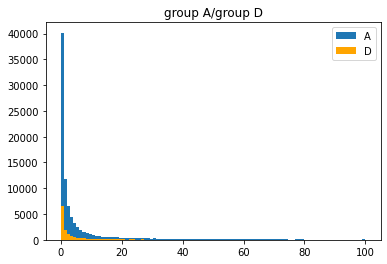

In [0]:
bins = np.linspace(0, 100, 100)

plt.hist(A, bins=bins, label='A')
plt.hist(D, bins=bins, label='D', color='orange')
plt.title('group A/group D')
plt.legend()

С помощью бутстрапа измеряем среднее и также доверительные интервалы

In [0]:
N = len(A)
s = 5000

X_a = np.random.choice(A, size=(s, N), replace=True)
T = lambda x: np.mean(x, axis=1
                      )
A_means= T(X_a)

In [0]:
np.mean(A_means)

10.100311335045207

In [0]:
np.percentile(A_means,[2.25,97.5])

array([ 9.94393538, 10.253883  ])

In [0]:
N = len(A)
s = 5000

X_d = np.random.choice(D, size=(s, N), replace=True)
D_means = T(X_d)

In [0]:
np.mean(D_means)

9.941531152493365

In [0]:
np.percentile(D_means,[2.25,97.5])

array([ 9.80003919, 10.08488202])

In [0]:
np.percentile((D_means - A_means),[2.25,97.5])

array([-0.3659533 ,  0.04901927])

In [0]:
np.mean((D_means - A_means))

-0.1587801825518417

In [0]:
len(A), len(D)

(92686, 15413)

In [0]:
A.mean(), D.mean()

(10.099561961892842, 9.942386297281516)

In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def boot_matrix(z, B):
    """Bootstrap sample
    
    Returns all bootstrap samples in a matrix"""
    
    n = len(z)  # sample size
    idz = np.random.randint(0, n, size=(B, n))  # indices to pick for all boostrap samples
    return z[idz]

def bootstrap_mean(x, B=10000, alpha=0.05, plot=False):
    """Bootstrap standard error and (1-alpha)*100% c.i. for the population mean
    
    Returns bootstrapped standard error and different types of confidence intervals"""
   
    # Deterministic things
    n = len(x)  # sample size
    orig = x.mean()  # sample mean
    se_mean = x.std()/np.sqrt(n) # standard error of the mean
    qt = stats.t.ppf(q=1 - alpha/2, df=n - 1) # Student quantile
    
    # Generate boostrap distribution of sample mean
    xboot = boot_matrix(x, B=B)
    sampling_distribution = xboot.mean(axis=1)
   
   # Standard error and sample quantiles
    se_mean_boot = sampling_distribution.std()
    quantile_boot = np.percentile(sampling_distribution, q=(100*alpha/2, 100*(1-alpha/2)))
 
    # RESULTS
    print("Estimated mean:", orig)
    print("Classic standard error:", se_mean)
    print("Classic student c.i.:", orig + np.array([-qt, qt])*se_mean)
    print("\nBootstrap results:")
    print("Standard error:", se_mean_boot)
    print("t%time bootstrap_mean(A, plot=True)-type c.i.:", orig + np.array([-qt, qt])*se_mean_boot)
    print("Percentile c.i.:", quantile_boot)
    print("Basic c.i.:", 2*orig - quantile_boot[::-1])

    if plot:
        plt.hist(sampling_distribution, bins="fd")


# https://github.com/mayer79/Bootstrap-p-values/blob/master/Bootstrap%20p%20values.ipynb

In [0]:
%time bootstrap_mean(A, plot=True)

Estimated mean: 10.099561961892842
Classic standard error: 0.07597470163330819
Classic student c.i.: [ 9.95065234 10.24847159]

Bootstrap results:
Standard error: 0.07631386547353773
t%time bootstrap_mean(A, plot=True)-type c.i.: [ 9.94998758 10.24913634]
Percentile c.i.: [ 9.94836221 10.24875116]
Basic c.i.: [ 9.95037276 10.25076171]


<IPython.core.display.Javascript object>

CPU times: user 15.4 s, sys: 6.15 s, total: 21.6 s
Wall time: 21.6 s


<IPython.core.display.Javascript object>

In [0]:
%time bootstrap_mean(D, plot=True)

Estimated mean: 9.942386297281516
Classic standard error: 0.17561173587997891
Classic student c.i.: [ 9.59816659 10.28660601]

Bootstrap results:
Standard error: 0.173768118693974
t%time bootstrap_mean(A, plot=True)-type c.i.: [ 9.60178029 10.2829923 ]
Percentile c.i.: [ 9.60649127 10.28878706]
Basic c.i.: [ 9.59598553 10.27828132]


<IPython.core.display.Javascript object>

CPU times: user 1.49 s, sys: 9.21 ms, total: 1.49 s
Wall time: 1.49 s


<IPython.core.display.Javascript object>

Так же, на всякий случай вычисляем п-валью с помощью бутстрапа

In [0]:
def bootstrap_t_pvalue(x, y, equal_var=False, B=10000, plot=False):
    """Bootstrap p values for two-sample t test
    
    Returns boostrap p value, test statistics and parametric p value"""
    
    # Original t test statistic
    orig = stats.ttest_ind(x, y, equal_var=equal_var)
    
    # Generate boostrap distribution of t statistic
    xboot = boot_matrix(x - x.mean(), B=B) # important centering step to get sampling distribution under the null
    yboot = boot_matrix(y - y.mean(), B=B)
    
    # welch's test
    sampling_distribution = stats.ttest_ind(xboot, yboot, axis=1, equal_var=equal_var)[0]

    # Calculate proportion of bootstrap samples with at least as strong evidence against null    
    p = np.mean(sampling_distribution >= orig[0])
    
    # RESULTS
    print("p value for null hypothesis of equal population means:")
    print("Parametric:", orig[1])
    print("Bootstrap:", 2*min(p, 1-p))
    
    # Plot bootstrap distribution
    if plot:
        plt.figure()
        plt.hist(sampling_distribution, bins="fd")

# https://github.com/mayer79/Bootstrap-p-values/blob/master/Bootstrap%20p%20values.ipynb

In [0]:
np.random.seed(984564) # for reproducability
%time bootstrap_t_pvalue(A, D, plot=True)

p value for null hypothesis of equal population means:
Parametric: 0.41141805919367513
Bootstrap: 0.4232


<IPython.core.display.Javascript object>

CPU times: user 20 s, sys: 1.04 s, total: 21 s
Wall time: 21 s


<IPython.core.display.Javascript object>

## Вывод
Распределения похожи, среднее выше в группе А, однако дисперсия больше в групе D и их доверительные интервалы  пересекаются. Согласно   п-валью Welch's test  и п-валью, полученной с помощью бутстрапа, мы не можем отвергнуть гипотезу о равенстве средних, таким образом, данные не позволяют сделать статистически значимый вывод о том, какая из групп лучше

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

Ну во-первых, по графику видно, что распределение сильно скошено, достаточно много аутлайерс - значит, скорее всего дисперсия большая. 

В общем, можно оценить дисперсию с помощью бутстрапа.  

Оценки дисперсии функционалов
Пусть есть выборка $X = \{x_i\}_{i=1}^{n}$, некоторый функционал $T_n(X)$ (например, среднее) и мы хотим оценить дисперсию $D_F(T_n)$. Не зная истинного распределения это можно сделать с помощью непараметрического или параметрического бутстрапа.

В непараметрическом бутстрапе оценка дисперсии делается следующим образом:

Рэсемплим выборку с возвращением B раз: $X_1^*, X_2^*, X_B^* \sim X$
Вычисляем $T_1^*, ..., T_B^*$
$$D_F(T_n) \approx v_{boot} = \frac{1}{B - 1} \sum\limits_{b=1}^B \left(T_b^* - \bar{T}^* \right)^2$$

In [0]:
data4 = pd.read_csv('/content/drive/My Drive/test_1_1.csv', sep=';')

In [0]:
data4

,Unnamed: 0,metrics
0,1,1
1,2,1
2,3,4
3,4,1
4,5,1
...,...,...
306834,306835,8
306835,306836,11
306836,306837,1
306837,306838,81


In [0]:
data4.metrics.describe()

count    306839.000000
mean         10.146275
std          22.627378
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max         998.000000
Name: metrics, dtype: float64

In [0]:
X = data4.metrics.values

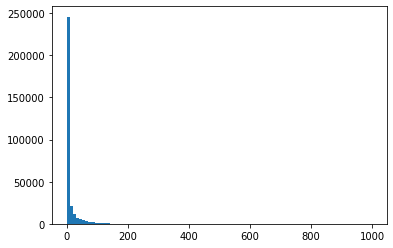

In [0]:
plt.hist(data4.metrics.values, bins=100)
plt.show()

Оценим дисперсию с помощью бутстрапа

In [0]:
N = len(X)
s = 1000
X_boosted = np.random.choice(X, size=(s,N), replace=True)
T = lambda x: np.var(x,axis=1
                      )

#np.random.choice(X, size=(1000, len(X))).mean(axis=1)
X_vars = T(X_boosted)

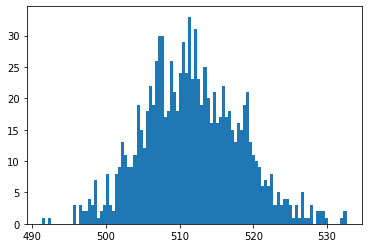

In [0]:
plt.hist(X_vars, bins=100)
plt.show()

In [0]:
X.var()

511.99656406405427

In [0]:
np.mean(X_vars)

511.66926696569334

Дисперсия и впрямь большая, что уменьшает чувствительность, нужно это как-то исправить. На самом деле, первое, что пришло в голову - это удаление аутлаеров - совсем чуть-чуть, но дисперсию самой выборки сокращает прилично. Однако, согласно многим источникам это некорректно, так как можно удалить важные для эксперимента данные.

Для сокращения дисперсии применяем такой метод, как стратификация: делим выборку на страты, в них подсчитываем среднее - получаем меньшую подвыборку, которая сохраняет важные свойства боольшой выборки, но при этом имеет меньшую дисперсию.

In [0]:
np.percentile(X, 99)
X_cleaned = X[X<112]
X_cleaned.var()

276.7591371616091

 Брутфорс, но эффективно

# Методы для сокращения дисперсии

Существует много более деликатных методов для сокращения дисперсии. Например, пост и предстратификация, децильный метод, монтекарло. Особенно интересным показался Cuped, но его применить не получится, так как нет данных, собранных до эксперимента. CUPED значительно сокращает дисперсию и 
 меняет форму исходного распределения метрики. При этом важные статистики остаются интерпретированы. 

Попробуем стратификацию. Я нашла чудесное видео с объяснением от Яндекса. Слайд прилагаю

Стратификация: делим нашу выборку на подвыборки, на каком-тот основании. Здесь мы не знаем о природе данных, поэтому за основу я взяла просто перцентили. В каждой из страт подсчитываем метрику - в данном случае я просто взяла среднее, потом умножаем метрику из каждой страты, умноженную на вес: k/n,  где k - колво объектов в страте, а n -  размер выборки. Складываем все полученные таким образом значения (в нашем случае их будет 5) - и вуаля. Получаем среднее всей выборки. То же самое подсчитываем и для дисперсии.

In [0]:
#  разбиваем выборку на 10 равных частей - однако, так как слишком много единиц - все их пихаем в одну страту
np.percentile(X, [10, 20, 30, 40, 50, 60, 70, 80, 90])

array([ 1.,  1.,  1.,  1.,  2.,  3.,  5., 10., 29.])

Разбиваем выборку на страты s1 - s6

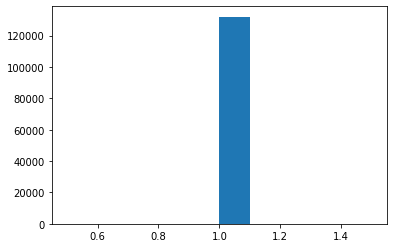

In [0]:
s1 = X[X<2]
plt.hist(s1)
plt.show()

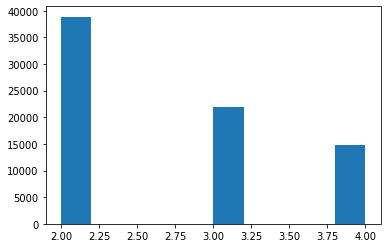

In [0]:
s2 = X[(X>=2) & (X<5)]
plt.hist(s2)
plt.show()

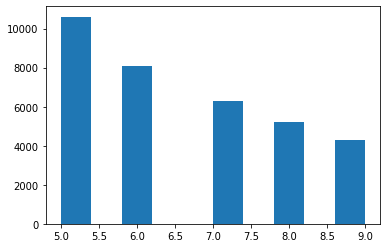

In [0]:
s3 = X[(X>=5) &(X<10)]
plt.hist(s3)
plt.show()

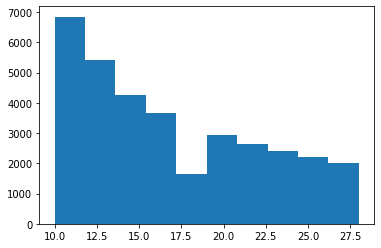

In [0]:
s4 = X[(X>=10) & (X<29)]
plt.hist(s4)
plt.show()

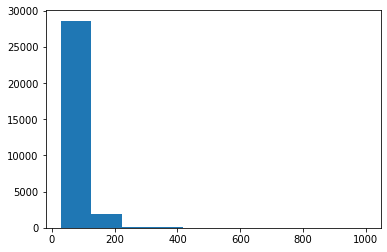

In [0]:
s5 = X[X>=29]
plt.hist(s5)
plt.show()

In [0]:
# список из кортежей (страта, ее длина)
strats = [(i, len(i)) for i in [s1,s2,s3,s4,s5]]

In [0]:
strats_means = []
for i, j in strats:
  mean_weighted = (j/len(X))*i.mean()
  strats_means.append(mean_weighted)

strats_means = np.array(strats_means)

In [0]:
 strats_means

array([0.43032665, 0.66030068, 0.73651003, 1.86509212, 6.45404593])

Складываем и вжух- получаем среднее нашей выборки.

In [0]:
np.sum(strats_means) 

10.146275408276

In [0]:
X.mean()

10.146275408276

А что же насчет дисперсии - подсчитываем ее аутентичным образом

In [0]:
strats_vars = []
for i, j in strats:
  var_weighted = (j/len(X))*i.var()
  strats_vars.append(var_weighted)

strats_vars = np.array(strats_vars)

In [0]:
strats_vars

array([0.00000000e+00, 1.49857619e-01, 2.14971339e-01, 3.23715138e+00,
       1.57043070e+02])

Мейджик - дисперсия значительно уменьшилась!

In [0]:
np.sum(strats_vars)

160.6450505241014

In [0]:
X.var()

511.99656406405427

In [0]:
np.sum(strats_vars)/X.var()

0.31376196990260197

## Выводы

Удаление аутлаеров не всегда хороший вариант - есть и более аккуратные. В нашем случае для сокращения дисперсии метрики можно использовать такой метод, как стратификация.

**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

Порядок решения
Для начала нам нужна статистическая модель в виде распределения которое наиболее точно описывает данные.
Далее проводим стат тесты и выявляем является ли данная стат. модель значимой. Определяем наименее частые расхождения между теоретической стат. моделью и фактическим распределением.
Рассчитываем точечные и интервальные оценки распределения, чтобы с определенной уверенностью делать выводы о изменениях случайных величин.
С помошю найденой стат. модели мы можем строить утвержедения с определенной долей вероятности по поводу нахождения наблюдаемых величин в опеределенных пределах.

In [0]:
! wget https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv

--2020-04-14 16:17:05--  https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fdki267uilkfq7l/task5.csv [following]
--2020-04-14 16:17:05--  https://www.dropbox.com/s/raw/fdki267uilkfq7l/task5.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca17902c1e52251812c637aa825.dl.dropboxusercontent.com/cd/0/inline/A13G-4eTWrczQ_r9EAIRnFX7DirbRwiGhk-Qjzc64IcWu9IusoQQfbnk7TaJQGluXPZuBbMUWQ8zsdU6adnXduYKvwAm9HdYPfyxeL41z9iaHwwRM7gBXwgXe-ZUpV_x12Y/file# [following]
--2020-04-14 16:17:05--  https://uca17902c1e52251812c637aa825.dl.dropboxusercontent.com/cd/0/inline/A13G-4eTWrczQ_r9EAIRnFX7DirbRwiGhk-Qjzc64IcWu9IusoQQfbnk7TaJQGluXPZuBbMUWQ8zsdU6adnXduYKvwAm9HdYPfyxeL41z9iaHwwRM7gBXwgX

Прежде всего взглянем на данные, сделаем предположения и подберем метрику.

In [0]:
data5 = pd.read_csv('task5.csv')

In [0]:
data5.head()

,id,variant,view,action
0,88258,A,10,2
1,109938,A,3,1
2,117644,A,7,5
3,374080,A,9,9
4,662082,A,1,1


In [0]:
chunks = range(3)
for chunk in chunks:
  for index, row in data5[chunk*100:chunk*100+100].iterrows():
    print(row)
  break

id         88258
variant        A
view          10
action         2
Name: 0, dtype: object
id         109938
variant         A
view            3
action          1
Name: 1, dtype: object
id         117644
variant         A
view            7
action          5
Name: 2, dtype: object
id         374080
variant         A
view            9
action          9
Name: 3, dtype: object
id         662082
variant         A
view            1
action          1
Name: 4, dtype: object
id         1132588
variant          A
view            10
action           2
Name: 5, dtype: object
id         1138382
variant          A
view             1
action           1
Name: 6, dtype: object
id         1236064
variant          A
view             9
action           3
Name: 7, dtype: object
id         1385416
variant          A
view            11
action          10
Name: 8, dtype: object
id         1563198
variant          A
view             5
action           2
Name: 9, dtype: object
id         1616534
variant        

Исходя из тех показателей, которые у нас есть, кажется, разумной метрикой будет конверсия - те отношение кликов к количеству просмотров.

In [0]:
data5['metric'] = data5.action/data5.view

In [0]:
A = data5[data5.variant=='A']['metric']
B = data5[data5.variant=='B']['metric']

In [0]:
plt.hist(A)

In [0]:
A = data5[data5.variant=='A'][['view', 'action']]
B = data5[data5.variant=='B'][['view','action']]
len(A), len(B)

(4646, 3545)

(array([2.252e+03, 5.880e+02, 3.290e+02, 1.450e+02, 1.480e+02, 6.500e+01,
        3.000e+00, 1.200e+01, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

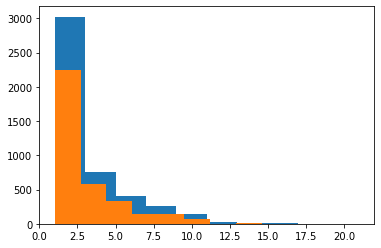

In [0]:
plt.hist(A['action'])
plt.hist(B['action'])

Находим конверсию для каждой из групп

In [0]:
A_conv = A.action.sum()/A.view.sum() * 100
B_conv = B.action.sum()/B.view.sum() * 100
A_conv, B_conv

(60.922031226912274, 60.61197506768244)

In [0]:
A = data5[data5.variant=='A']['metric'].values
B = data5[data5.variant=='B']['metric'].values

Взглянем на график,вообще распределения выглядят очень похоже, показатели в группе А несколько выше.

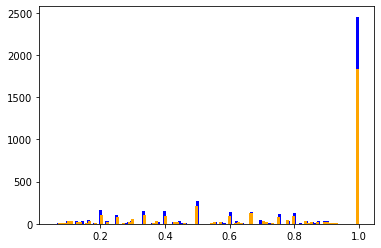

In [0]:
plt.hist(A, bins=100, color='blue')
plt.hist(B, bins=100, color='orange')
plt.show()

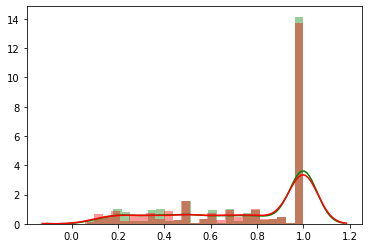

In [0]:
fig, ax = plt.subplots()
sns.distplot(A, bins=25, color="g", ax=ax)
sns.distplot(B, bins=25, color="r", ax=ax)
plt.show()

Составим краткое резюме по данным в виде таблички

In [0]:
Landing_AB = pd.DataFrame.from_dict({'groups':['A', 'B'],
                                   'views':[sum(data5[data5.variant=='A'].view.values), sum(data5[data5.variant=='B'].view.values)],
                                     'clicks':[sum(data5[data5.variant=='A'].action.values), sum(data5[data5.variant=='B'].action.values)], 
                                      'ctr':[A_conv, B_conv]})

In [0]:
Landing_AB

,groups,views,clicks,ctr
0,A,20303,12369,60.922031
1,B,15883,9627,60.611975


Сделаем z test. По результатам нельзя отвергнуть нулевую гипотезу о равенстве средних - те нет разницы между двумя группами.

In [0]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
z_score, p_value = sm.stats.proportions_ztest([Landing_AB['clicks'][0], Landing_AB['clicks'][1]], [Landing_AB['views'][0], Landing_AB['views'][1]], alternative='smaller')
z_score, p_value

(0.5995066080068987, 0.7255824475676005)

In [0]:
from scipy.stats import norm

print(norm.cdf(z_score))
# Tells us how significant our z-score is

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.7255824475676005
1.6448536269514722


Так как мы ничего не знаем о природе данных и их распределении - разумно применить бутстрап или же непараметрический тест (например, Манн-Уитни)

In [0]:
data5.head()

,id,variant,view,action,metric
0,88258,A,10,2,0.200000
1,109938,A,3,1,0.333333
2,117644,A,7,5,0.714286
3,374080,A,9,9,1.000000
4,662082,A,1,1,1.000000


In [0]:
stats.mannwhitneyu(A, B)

MannwhitneyuResult(statistic=8144665.5, pvalue=0.17854643929605546)

Также применим бутстрап для тестов и расчета п-валью

In [0]:
def plot_two_hist(data1, data2, bins=50):
    _, ax = plt.subplots(figsize=(20,8))
    ax.hist(data1, bins=bins)
    ax.hist(data2, bins=bins, alpha=0.8)

In [0]:
#расчет CTR
def ctr(series1, series2): return np.sum(series1)/np.sum(series2)

def botstrap(series1, series2, metric, samples=1000, n=None, isProgres=True):
    """Бутстреп семплирование"""
    
    metrics = []
    if not n: n = len(series1)//100
    iterable = range(samples) if isProgres else range(samples)
    for _ in iterable:
        sample_idx = np.random.randint(len(series1), size=n)
        metrics.append(metric(series1[sample_idx], series2[sample_idx]))

    return metrics

In [0]:
import scipy
A = data5[data5.variant=='A'][['view', 'action']]
B = data5[data5.variant=='B'][['view','action']]

exp bootstrap mean 0.6107
control bootstrap mean 0.6097
means_diff 0.0010,  Mann_Uhitney p-value:  0.073532


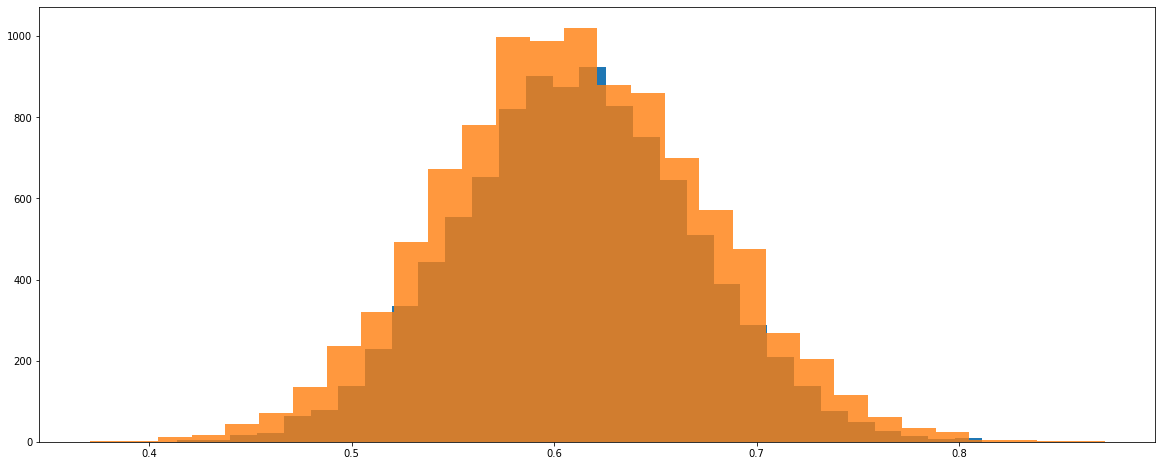

In [0]:
n_samples = 10000
#bootstrapping
ctr_botstrap_exp = botstrap(A['action'].values, A['view'].values, ctr, samples=n_samples)
ctr_botstrap_control = botstrap(B['action'].values, B['view'].values, ctr, samples=n_samples)

#plot
plot_two_hist(ctr_botstrap_exp, ctr_botstrap_control, bins=30)
print("exp bootstrap mean {0:.4f}\ncontrol bootstrap mean {1:.4f}".format(
    np.mean(ctr_botstrap_exp), np.mean(ctr_botstrap_control)))

#test
mannwhitneyu = scipy.stats.mannwhitneyu(ctr_botstrap_exp, ctr_botstrap_control, alternative='greater')
print('means_diff {0:.4f},  Mann_Uhitney p-value:  {1:.6f}'.
      format(np.mean(ctr_botstrap_exp)-np.mean(ctr_botstrap_control), mannwhitneyu[1]))

In [0]:
A = data5[data5.variant=='A']['metric'].values
B = data5[data5.variant=='B']['metric'].values

In [0]:
%time bootstrap_t_pvalue(A, B)

p value for null hypothesis of equal population means:
Parametric: 0.44680268552920255
Bootstrap: 0.4376
CPU times: user 1.72 s, sys: 36.8 ms, total: 1.76 s
Wall time: 1.76 s


Выводы: Средние пользовательских переходов CTR  не отличаются на контроле и в эксперименте

По результатам данного теста мы видим, что п-валью больше 0.05, а значит с 95 процентной уверенностью мы принимаем нулевую гипотезу о равенстве средних (одно и то же распределение?). А значит, нельзя сделать вывод о том, что какая-то группа лучше другой.